In [39]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold

# Validation
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import randint

# Explanation
# import shap

# Load the Excel file
file_path = 'content/FS_Dataset.xlsx'


In [2]:
# prompt: count and print sheets in the file

xls = pd.ExcelFile(file_path)
print(xls.sheet_names)
print(len(xls.sheet_names))


['Tổng hợp', 'Sheet1', 'Sheet8', 'Lý thuyết', 'Phân ngành', 'Giá', 'Tỷ suất cổ tức', 'Chỉ số', 'Chỉ số 2', 'BCTC 1', 'BCTC 2', 'BCTC 3', 'BCTC 4']
13


In [3]:
sheet_name = 'Tổng hợp'
df = pd.read_excel(file_path, sheet_name=sheet_name)

df.replace('nan', np.nan, inplace=True)
rows, cols = df.shape

print(f"Number of rows: {rows}")
print(f"Number of columns: {cols}")


Number of rows: 1665
Number of columns: 847


In [4]:
# df.head()

In [5]:
# #Count unique value of cols 0-6
# for col in df.columns[:6]:
#     counts = df[col].value_counts(dropna=False)
#     print(counts)

# Pre-processing

In [4]:
#Remain cols
cols = df.columns[6:]

groups = {}
trans_groups = {}

pattern = re.compile(r"(.*?)\n(.*?)\nNăm: (\d{4})\nĐơn vị: (.+)", re.DOTALL)

for col in cols:
    match = pattern.match(col)
    if match:
        attribute, status, year, unit = match.groups()
        if year not in groups:
            groups[year] = []
        groups[year].append(col)
        if year not in trans_groups:
            trans_groups[year] = []
        trans_groups[year].append(attribute + f'\nUnit: {unit}')
        
trans_cols = trans_groups['2010']

In [5]:
#Delete year "2024"
groups.pop('2024', None)
trans_groups.pop('2024', None)

print("In total, there are" ,len(trans_groups), "groups")
for idx,col in enumerate(trans_cols,start=0):
  print('-'*10)
  print(f"Attribute: {idx}: {col}")

In total, there are 14 groups
----------
Attribute: 0: I. TÀI SẢN NGẮN HẠN
Unit: VND
----------
Attribute: 1: 1. Tiền và tương đương tiền 
Unit: VND
----------
Attribute: 2: 4.1. Hàng tồn kho
Unit: VND
----------
Attribute: 3: 3. Các khoản phải thu ngắn hạn
Unit: VND
----------
Attribute: 4: 3.1. Phải thu ngắn hạn của khách hàng
Unit: VND
----------
Attribute: 5: II. TÀI SẢN DÀI HẠN
Unit: VND
----------
Attribute: 6: 2. Tài sản cố định
Unit: VND
----------
Attribute: 7: 2. Khấu hao TSCĐ và BĐSĐT (GT)
Unit: VND
----------
Attribute: 8: 1. Phải thu dài hạn
Unit: VND
----------
Attribute: 9: A. TỔNG CỘNG TÀI SẢN
Unit: VND
----------
Attribute: 10: I. NỢ PHẢI TRẢ
Unit: VND
----------
Attribute: 11: 1. Nợ ngắn hạn
Unit: VND
----------
Attribute: 12: 1.1. Phải trả người bán ngắn hạn
Unit: VND
----------
Attribute: 13: 2. Nợ dài hạn
Unit: VND
----------
Attribute: 14: II. VỐN CHỦ SỞ HỮU
Unit: VND
----------
Attribute: 15: 1.12. Lãi chưa phân phối
Unit: VND
----------
Attribute: 16: B. TỔNG CỘ

In [6]:
trans_df = pd.DataFrame(columns=list(df.columns[1:6]) + ['Year'] + trans_cols)
for year, cols in groups.items():
    new_df = pd.DataFrame(df[cols])
    new_df.columns = trans_cols
    new_df.insert(0, 'Year', year)
    concat_df = pd.concat([df[df.columns[1:6]], new_df], axis=1)
    trans_df = pd.concat([trans_df, concat_df], axis=0, ignore_index=True)

C:\Users\Jeff\AppData\Local\Temp\ipykernel_7584\1620107977.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trans_df = pd.concat([trans_df, concat_df], axis=0, ignore_index=True)


Split dataset into 2 part: financial firms and non-financial firms

Use separate methods, models, techniques to identify firms financial distress

https://chatgpt.com/share/67568793-ce38-8009-bdde-3ca5db894696

In [7]:
print('Before drop NaN: ',trans_df.shape)

trans_df.dropna(inplace=True)
# 'Phân ngành - ICB L1' is 'Ngân hàng' or 'Tài chính'
fin_df = trans_df[trans_df['Phân ngành - ICB L1'].isin(['Ngân hàng', 'Tài chính'])]
# The rest
nonfin_df = trans_df[~trans_df['Phân ngành - ICB L1'].isin(['Ngân hàng', 'Tài chính'])]

# Set index
fin_df.set_index(fin_df.columns[:6].tolist(), inplace=True)
nonfin_df.set_index(nonfin_df.columns[:6].tolist(), inplace=True)

print('After drop NaN: ',trans_df.shape)
print('Financial firms: ',fin_df.shape)
print('Non-financial firms: ',nonfin_df.shape)

Before drop NaN:  (23310, 61)
After drop NaN:  (11897, 61)
Financial firms:  (1071, 55)
Non-financial firms:  (10826, 55)


In [10]:
nonfin_df.head()

,,,,,,I. TÀI SẢN NGẮN HẠN\nUnit: VND,1. Tiền và tương đương tiền \nUnit: VND,4.1. Hàng tồn kho\nUnit: VND,3. Các khoản phải thu ngắn hạn\nUnit: VND,3.1. Phải thu ngắn hạn của khách hàng\nUnit: VND,II. TÀI SẢN DÀI HẠN\nUnit: VND,2. Tài sản cố định\nUnit: VND,2. Khấu hao TSCĐ và BĐSĐT (GT)\nUnit: VND,1. Phải thu dài hạn\nUnit: VND,A. TỔNG CỘNG TÀI SẢN\nUnit: VND,...,EPS cơ bản\nUnit: VND,P/E cơ bản\nUnit: Lần,P/B\nUnit: Lần,Giá trị DN/ EBITDA \nUnit: Lần,Tỷ suất thanh toán cổ tức \nUnit: %,Tổng vốn vay/ VSCH\nUnit: Lần,"Tăng trưởng đầu tư tài sản cố định (CAPEX) (YoY) (Quý, Năm)\nUnit: %",Tăng tưởng doanh thu thuần 3 năm - CAGR (Y)\nUnit: %,Tăng trưởng lợi nhuận trước thuế 3 năm - CAGR (Y)\nUnit: %,Tăng trưởng lợi nhuận thuần 3 năm - CAGR (Y)\nUnit: %
Mã,Tên công ty,Sàn,Phân ngành - ICB L1,Phân ngành - ICB L2,Year,,,,,,,,,,,,,,,,,,,,,
AAA,An Phát Bioplastics,HOSE,Nguyên vật liệu,Hóa chất,2010,2.846300e+11,2.019609e+10,8.061924e+10,1.619500e+11,7.347897e+10,3.603485e+11,3.440407e+11,2.569418e+10,0.0,6.449785e+11,...,9113.67,2.70,0.76,3.24,0.1003,0.79,1.0053,0.8430,0.8253,0.7651
AAM,Thủy sản Mekong,HOSE,Hàng Tiêu dùng,Thực phẩm và đồ uống,2010,2.493097e+11,7.636546e+10,4.872882e+10,1.138584e+11,7.915940e+10,8.202656e+10,7.529071e+10,7.677012e+09,0.0,3.313362e+11,...,4027.81,2.52,0.39,1.04,0.7448,0.02,0.5932,0.1298,0.3068,0.2967
ACC,Đầu tư và XD Bình Dương ACC,HOSE,Công nghiệp,Xây dựng và Vật liệu,2010,1.553532e+11,2.612851e+10,3.783467e+10,9.059738e+10,9.053369e+10,8.477105e+10,6.089117e+10,1.275513e+10,0.0,2.401243e+11,...,5828.09,5.32,1.80,3.93,0.8579,0.00,0.3683,0.0000,0.0000,0.0000
ACL,Thủy sản CL An Giang,HOSE,Hàng Tiêu dùng,Thực phẩm và đồ uống,2010,5.256698e+11,4.235816e+10,2.172929e+11,2.550918e+11,2.403435e+11,2.004151e+11,1.925987e+11,1.320829e+10,0.0,7.260849e+11,...,5417.93,1.46,0.38,5.21,0.5537,1.88,0.2238,0.4116,0.1090,0.1461
ANV,Thủy sản Nam Việt,HOSE,Hàng Tiêu dùng,Thực phẩm và đồ uống,2010,1.011882e+12,7.116081e+10,2.667755e+11,5.702398e+11,5.863379e+11,9.211727e+11,6.646102e+11,9.650989e+10,0.0,1.933054e+12,...,1069.83,5.12,0.25,5.92,0.8413,0.20,0.1036,-0.2346,-0.4523,-0.4245


# Research Methodology

## Financial Distress Identification

### Identification from Experts

https://www.investopedia.com/articles/financial-theory/10/spotting-companies-in-financial-distress.asp

https://doi.org/10.3390/data7110160

https://doi.org/10.1016/j.ecosys.2018.05.002: traditional models

### Variable Measurement

#### Model 1: Z-Score of Altman (1968)

https://www.bajajfinserv.in/altman-z-score

In [8]:
# X1: Working Capital-to-Total Assets Ratio (WCTA): Tỷ lệ vốn lưu động trên tổng tài sản
# Measurement: (Current Assets(0) - Current Liabilities(11)) / Total Assets(9)
X1 = nonfin_df.apply(
    lambda row: (row[trans_cols[0]] - row[trans_cols[11]]) / row[trans_cols[9]]
    if pd.notna(row[trans_cols[0]]) and pd.notna(row[trans_cols[11]])
    and pd.notna(row[trans_cols[9]]) and row[trans_cols[9]] != 0
    else np.nan, axis=1
)

# X2 = Retained earnings divided by total assets
# https://sapp.edu.vn/bai-viet-cma/retained-earnings-la-gi/
# https://www.investopedia.com/terms/r/retainedearnings.asp
X2 = nonfin_df.apply(
    lambda row : row[trans_cols[15]] / row[trans_cols[9]]
    if pd.notna(row[trans_cols[15]]) and pd.notna(row[trans_cols[9]])
    and row[trans_cols[9]] != 0
    else np.nan, axis=1
)

# X3 = Profit before tax and interests (EBIT) divided by total assets
X3 = nonfin_df.apply(
    lambda row: (row[trans_cols[26]] + row[trans_cols[22]]) / row[trans_cols[9]]
    if pd.notna(row[trans_cols[26]]) and pd.notna(row[trans_cols[22]])
    and pd.notna(row[trans_cols[9]])
    and row[trans_cols[9]] != 0
    else np.nan, axis=1
)

# X4 = Equity market value divided by total debts
X4 = nonfin_df.apply(
    lambda row : row[trans_cols[29]] / row[trans_cols[10]]
    if pd.notna(row[trans_cols[29]]) and pd.notna(row[trans_cols[10]])
    and row[trans_cols[10]] != 0
    else np.nan, axis=1
)

# X5 = Revenue divided by total assets
X5 = nonfin_df.apply(
    lambda row : row[trans_cols[18]] / row[trans_cols[9]]
    if pd.notna(row[trans_cols[18]]) and pd.notna(row[trans_cols[9]])
    and row[trans_cols[9]] != 0
    else np.nan, axis=1
)

# Z-Score for public manufacturing companies
Z_1983 = 1.2*X1 + 1.4*X2 + 3.3*X3 + 0.6*X4 + 1.0*X5

#### Model 2: X-Score of Zmijewski (1984)

In [9]:
# X1 = ROA (39) = Net profit divided by total assets
X1 = nonfin_df.apply(
    lambda row : row[trans_cols[39]]
    if pd.notna(row[trans_cols[39]])
    else np.nan, axis=1
)

# X2 = FINL = Total debt(10) to total assets(9)
X2 = nonfin_df.apply(
    lambda row : row[trans_cols[10]] / row[trans_cols[9]]
    if pd.notna(row[trans_cols[10]]) and pd.notna(row[trans_cols[9]])
    and row[trans_cols[9]] != 0
    else np.nan, axis=1
)

# X1 = Current ratio = Current assets divided by current liabilities
X3 = nonfin_df.apply(
    lambda row : row[trans_cols[0]] / row[trans_cols[11]]
    if pd.notna(row[trans_cols[0]]) and pd.notna(row[trans_cols[11]])
    and row[trans_cols[11]] != 0
    else np.nan, axis=1
)

X_1984 = -4.3 - 4.5*X1 + 5.7*X2 + 0.004*X3

#### Labeling

1: High risk of bankruptcy

0: Non-bankrupt firms

In [10]:
result_model1 = Z_1983.apply(
    lambda row: 1 if row < 1.81 else # high risk of bankruptcy
                0 if row > 1.81 else # non-bankrupt firms 
                np.nan
)

result_model2 = X_1984.apply(
    lambda row: 1 if row > 0 else # high risk of bankruptcy
                0 if row < 0 else # non-bankrupt firms 
                np.nan
)

FD_iden_df = pd.DataFrame()
FD_iden_df ['Model 1 - Altman'] = result_model1
FD_iden_df ['Model 2 - Zmijewski'] = result_model2

FD_iden_df

,,,,,,Model 1 - Altman,Model 2 - Zmijewski
Mã,Tên công ty,Sàn,Phân ngành - ICB L1,Phân ngành - ICB L2,Year,,
AAA,An Phát Bioplastics,HOSE,Nguyên vật liệu,Hóa chất,2010,0,0
AAM,Thủy sản Mekong,HOSE,Hàng Tiêu dùng,Thực phẩm và đồ uống,2010,0,0
ACC,Đầu tư và XD Bình Dương ACC,HOSE,Công nghiệp,Xây dựng và Vật liệu,2010,0,0
ACL,Thủy sản CL An Giang,HOSE,Hàng Tiêu dùng,Thực phẩm và đồ uống,2010,0,0
ANV,Thủy sản Nam Việt,HOSE,Hàng Tiêu dùng,Thực phẩm và đồ uống,2010,0,0
...,...,...,...,...,...,...,...
XMC,Bê tông Xuân Mai,UPCoM,Công nghiệp,Xây dựng và Vật liệu,2023,1,0
XMD,Xuân Mai - Đạo Tú,UPCoM,Công nghiệp,Xây dựng và Vật liệu,2023,1,0
XMP,Thủy điện Xuân Minh,UPCoM,Tiện ích Cộng đồng,"Điện, nước & xăng dầu khí đốt",2023,1,0


## Features in Research models

### Appendix A

In [11]:
atr = pd.DataFrame()

# Atr X1: EBIT Margin: Earnings before interest and taxes Margin: Biên lợi nhuận trước lãi vay và thuế
# Measurement: EBIT Margin = (Lợi nhuận trước thuế(26) + Chi phí lãi vay(22)) / Doanh thu thuần(18)
X1 = nonfin_df.apply(
    lambda row: (row[trans_cols[26]] + row[trans_cols[22]]) / row[trans_cols[18]]
    if pd.notna(row[trans_cols[26]]) and pd.notna(row[trans_cols[22]])
    and pd.notna(row[trans_cols[18]]) and row[trans_cols[18]] != 0
    else 0, axis=1
)
atr['X1: EBIT Margin'] = X1

# Atr X2: EBITDA Margin: Earning Before Interest, Taxes, Depreciation and Amortization Margin:
# Biên thu nhập trước lãi vay, thuế, khấu hao và khấu hao tài sản cố định
# Measurement: EBITDA Margin = (Lợi nhuận trước thuế(26) + Lãi Vay(22) + Khấu hao(7)) / Doanh thu thuần(18)
X2 = nonfin_df.apply(
    lambda row: (row[trans_cols[26]] + row[trans_cols[22]] + row[trans_cols[7]]) / row[trans_cols[18]]
    if pd.notna(row[trans_cols[26]]) and pd.notna(row[trans_cols[22]])
    and pd.notna(row[trans_cols[7]]) and pd.notna(row[trans_cols[18]]) and row[trans_cols[18]] != 0
    else 0, axis=1
)
atr['X2: EBITDA Margin'] = X2

### SOLVENCY: KHẢ NĂNG THANH TOÁN ###

# Atr X3: Current ratio: Tỷ số thanh khoản hiện thời
# Measurement: Current assets/Short-term liabilities: Tài sản ngắn hạn / Nợ ngắn hạn
X3 = nonfin_df.apply(
    lambda row: row[trans_cols[0]] / row[trans_cols[11]] if
    pd.notna(row[trans_cols[0]]) and pd.notna(row[trans_cols[11]]) and
    row[trans_cols[11]] != 0 else np.nan, axis=1
)
atr['X3: Current ratio'] = X3

# Atr X4: Quick ratio: Tỷ số thanh toán nhanh
# Measurement: (Current assets – inventories)/Current liabilities: (Tài sản ngắn hạn – hàng tồn kho) / Nợ ngắn hạn
X4 = nonfin_df.apply(
    lambda row: (row[trans_cols[0]] - row[trans_cols[2]])/row[trans_cols[11]] if
    pd.notna(row[trans_cols[0]]) and pd.notna(row[trans_cols[2]]) and pd.notna(row[trans_cols[11]])
    and row[trans_cols[11]] != 0 else np.nan, axis=1
)
atr['X4: Quick ratio'] = X4

# Atr X5: Cash ratio: Tỷ suất thanh toán tiền mặt
# Measurement: 34
X5 = nonfin_df.apply(
    lambda row: row[trans_cols[34]] if pd.notna(row[trans_cols[34]])
    else np.nan, axis=1
)
atr['X5: Cash ratio'] = X5

# Atr X6: Working Capital-to-Total Assets Ratio (WCTA): Tỷ lệ vốn lưu động trên tổng tài sản
# Measurement: (Current Assets(0) - Current Liabilities(11)) / Total Assets(9)
# Source: https://cashflowfrog.com/blog/net-working-capital-formula/#:~:text=The%20net%20working%20capital%20ratio,up%20in%20net%20working%20capital.
# https://www.investopedia.com/terms/w/workingcapital.asp
X6 = nonfin_df.apply(
    lambda row: (row[trans_cols[0]] - row[trans_cols[11]]) / row[trans_cols[9]]
    if pd.notna(row[trans_cols[0]]) and pd.notna(row[trans_cols[11]])
    and pd.notna(row[trans_cols[9]]) and row[trans_cols[9]] != 0
    else np.nan, axis=1
)
atr['X6: WCTA'] = X6

# Atr X7: Debt-to-equity ratio: Tỉ số tổng nợ trên vốn chủ sở hữu
# Measurement: Total liabilities (10) / Shareholder Equity (14)
# Source: https://www.investopedia.com/terms/d/debtequityratio.asp
# https://www.vietcap.com.vn/kien-thuc/ty-le-no-tren-von-chu-so-huu-d-e-ratio-co-y-nghia-gi
X7 = nonfin_df.apply(
    lambda row: row[trans_cols[10]] / row[trans_cols[14]]
    if pd.notna(row[trans_cols[10]])
    and pd.notna(row[trans_cols[14]]) and row[trans_cols[14]] != 0
    else np.nan, axis=1
)
atr['X7: D/E ratio'] = X7

### OPERATIONAL EFFICIENCY: Hiệu quả hoạt động ###

# Atr X8: Receivables turnover: Vòng quay khoản phải thu
# Measurement: 35: Net revenue/Receivables
X8 = nonfin_df.apply(
    lambda row: row[trans_cols[35]] if pd.notna(row[trans_cols[35]])
    else np.nan, axis=1
)
atr['X8: Receivables turnover'] = X8

# Atr X9: Inventory turnover: Vòng quay hàng tồn kho
# Measurement: 36: Cost of Goods Sold / Average Inventory: giá vốn hàng bán / giá trị hàng tồn kho trung bình
X9 = nonfin_df.apply(
    lambda row: row[trans_cols[36]] if pd.notna(row[trans_cols[36]])
    else np.nan, axis=1
)
atr['X9: Inventory turnover'] = X9

# Atr X10: Accounts payable turnover: Vòng quay khoản trả nhà cung cấp
# Measurement: 37
# https://www.investopedia.com/terms/a/accountspayableturnoverratio.asp
X10 = nonfin_df.apply(
    lambda row: row[trans_cols[37]] if pd.notna(row[trans_cols[37]])
    else np.nan, axis=1
)
atr['X10: AP turnover'] = X10

# Atr X11: Asset turnover: Vòng quay tài sản
# Measurement: 38: Net Sales / Average total assets: doanh thu thuần / trung bình tổng tài sản
# https://www.investopedia.com/terms/a/assetturnover.asp
X11 = nonfin_df.apply(
    lambda row: row[trans_cols[38]] if pd.notna(row[trans_cols[38]])
    else np.nan, axis=1
)
atr['X11: Asset turnover'] = X11

# Atr X12: Current assets turnover
# Measurement: Net Revenue(18) / Current assets(0): Doanh thu thuần / Tài sản ngắn hạn
# Source: https://www.tutorialspoint.com/how-is-current-asset-turnover-ratio-calculated
X12 = nonfin_df.apply(
    lambda row: row[trans_cols[18]] / row[trans_cols[0]]
    if pd.notna(row[trans_cols[18]])
    and pd.notna(row[trans_cols[0]]) and row[trans_cols[0]] != 0
    else np.nan, axis=1
)
atr['X12: Current assets turnover'] = X12

### PROFITABILITY: KHẢ NĂNG SINH LỢI ###

# Atr X13: Return on Assets (ROA): Tỷ số lợi nhuận ròng trên tổng tài sản
# Measurement: 39
# Source: https://www.investopedia.com/terms/r/returnonassets.asp
X13 = nonfin_df.apply(
    lambda row: row[trans_cols[39]] if pd.notna(row[trans_cols[39]])
    else np.nan, axis=1
)
atr['X13: ROA %'] = X13

# Atr X14: Return on Equity (ROE): tỷ số lợi nhuận ròng trên vốn chủ sở hữu
# Measurement: 40
# Source: https://www.investopedia.com/terms/r/returnonequity.asp
X14 = nonfin_df.apply(
    lambda row: row[trans_cols[40]] if pd.notna(row[trans_cols[40]])
    else np.nan, axis=1
)
atr['X14: ROE %'] = X14

# Atr X15: Return on Invested Capital (ROIC): tỷ số sinh lời trên vốn đầu tư
# Measurement: 41
# Source: https://www.investopedia.com/terms/r/returnoninvestmentcapital.asp
X15 = nonfin_df.apply(
    lambda row: row[trans_cols[41]] if pd.notna(row[trans_cols[41]])
    else np.nan, axis=1
)
atr['X15: ROIC %'] = X15

# Profit Margin: https://www.investopedia.com/terms/p/profitmargin.asp
# https://www.investopedia.com/terms/r/revenue.asp

# Atr X16: Gross Profit Margin (42): Biên lợi nhuận gộp
# Measurement: Gross profit (20) / Net Revenue(18): Lợi nhuận gộp/Doanh thu thuần
# Source: https://www.investopedia.com/terms/g/gross_profit_margin.asp
X16 = nonfin_df.apply(
    lambda row: row[trans_cols[20]] / row[trans_cols[18]]
    if pd.notna(row[trans_cols[20]])
    and pd.notna(row[trans_cols[18]]) and row[trans_cols[18]] != 0
    else 0 if row[trans_cols[18]] == 0
    else np.nan, axis=1
)
atr['X16: Gross Profit Margin'] = X16

# Atr X17: Operating Profit Margin: 
# Measurement: Operating Profit (EBIT) / Net Revenue(18): EBIT/Doanh thu thuần
# Source: https://1office.vn/profit-margin-la-gi
# https://www.investopedia.com/terms/o/operatingmargin.asp
X17 = nonfin_df.apply(
    lambda row: (row[trans_cols[26]] + row[trans_cols[22]]) / row[trans_cols[18]]
    if pd.notna(row[trans_cols[26]]) and pd.notna(row[trans_cols[22]])
    and pd.notna(row[trans_cols[18]]) and row[trans_cols[18]] != 0
    else 0 if row[trans_cols[18]] == 0
    else np.nan, axis=1
)
atr['X17: Operating Profit Margin'] = X17

# Atr X18: Net Profit Margin (43): Biên lợi nhuận ròng
# Measurement: Net profit (28) / Net Revenue(18): Lợi nhuận sau thuế/Doanh thu thuần
# Source: https://1office.vn/profit-margin-la-gi
# https://www.investopedia.com/terms/n/net_margin.asp
X18 = nonfin_df.apply(
    lambda row: row[trans_cols[28]] / row[trans_cols[18]]
    if pd.notna(row[trans_cols[28]])
    and pd.notna(row[trans_cols[18]]) and row[trans_cols[18]] != 0
    else 0 if row[trans_cols[18]] == 0
    else np.nan, axis=1
)
atr['X18: Net Profit Margin'] = X18

### GROWTH CAPABILITY: CƠ HỘI TĂNG TRƯỞNG ###

# Attribute: 51: Tăng trưởng đầu tư tài sản cố định (CAPEX) (YoY) (Quý, Năm)
# Attribute: 52: Tăng tưởng doanh thu thuần 3 năm - CAGR (Y)
# Attribute: 53: Tăng trưởng lợi nhuận trước thuế 3 năm - CAGR (Y)
# Attribute: 54: Tăng trưởng lợi nhuận thuần 3 năm - CAGR (Y)

# Atr X19: Tăng trưởng đầu tư tài sản cố định (CAPEX) (YoY) (Quý, Năm)
# Measurement: 51
# Source: https://www.investopedia.com/terms/c/capitalexpenditure.asp
# https://www.investopedia.com/terms/y/year-over-year.asp
X19 = nonfin_df.apply(
    lambda row: row[trans_cols[51]] if pd.notna(row[trans_cols[51]])
    else np.nan, axis=1
)
atr['X19: CAPEX YoY'] = X19

# Compound Annual Growth Rate (CAGR)
# https://www.investopedia.com/terms/c/cagr.asp

# Atr X20: Revenue Growth 3Y: Tăng tưởng doanh thu thuần 3 năm - CAGR (Y)
# Measurement: 52
# Source:
X20 = nonfin_df.apply(
    lambda row: row[trans_cols[52]] if pd.notna(row[trans_cols[52]])
    else np.nan, axis=1
)
atr['X20: Revenue Growth 3Y'] = X20

# Atr X21: Profit Before Tax (PBT) Growth: Tăng trưởng lợi nhuận trước thuế 3 năm - CAGR (Y)
# Measurement: 53
# Source: https://www.investopedia.com/terms/p/profitbeforetax.asp
X21 = nonfin_df.apply(
    lambda row: row[trans_cols[53]] if pd.notna(row[trans_cols[53]])
    else np.nan, axis=1
)
atr['X21: PBT Growth'] = X21

# Atr X22: Net Profit Growth: Tăng trưởng lợi nhuận thuần 3 năm - CAGR (Y)
# Measurement: 54
# Source: https://www.investopedia.com/terms/n/netincome.asp
X22 = nonfin_df.apply(
    lambda row: row[trans_cols[54]] if pd.notna(row[trans_cols[54]])
    else np.nan, axis=1
)
atr['X22: Net Profit Growth'] = X22

### RISK LEVEL: MỨC ĐỘ RỦI RO ###

# Atr X23: Total Debt on Total Assets
# Measurement: Tổng nợ (10) / Tổng tài sản (9)
# Source: https://www.investopedia.com/terms/t/totaldebttototalassets.asp
X23 = nonfin_df.apply(
    lambda row: row[trans_cols[10]] / row[trans_cols[9]]
    if pd.notna(row[trans_cols[10]])
    and pd.notna(row[trans_cols[10]]) and row[trans_cols[9]] != 0
    else np.nan, axis=1
)
atr['X23: Total Debt on Total Assets'] = X23

### OTHERS ###

# Attribute: 45: EPS cơ bản
# Attribute: 46: P/E cơ bản
# Attribute: 47: P/B
# Attribute: 48: Giá trị DN/ EBITDA
# Attribute: 49: Tỷ suất thanh toán cổ tức

# Atr X24: Basic Earnings Per Share (EPS): EPS cơ bản
# Measurement: 45
# Source: https://www.investopedia.com/terms/e/eps.asp
X24 = nonfin_df.apply(
    lambda row: row[trans_cols[45]] if pd.notna(row[trans_cols[45]])
    else np.nan, axis=1
)
atr['X24: Basic EPS'] = X24

# Atr X25: Basic Price-to-Earnings (P/E): P/E cơ bản
# Measurement: 46
# Source: https://www.investopedia.com/terms/p/price-earningsratio.asp
# https://vnexpress.net/chi-so-p-b-p-e-la-gi-4296226.html
X25 = nonfin_df.apply(
    lambda row: row[trans_cols[46]] if pd.notna(row[trans_cols[46]])
    else np.nan, axis=1
)
atr['X25: Basic P/E'] = X25

# Atr X26: Price-to-Book (P/B)
# Measurement: 47
# Source: https://www.investopedia.com/terms/p/price-to-bookratio.asp
# https://vnexpress.net/chi-so-p-b-p-e-la-gi-4296226.html
X26 = nonfin_df.apply(
    lambda row: row[trans_cols[47]] if pd.notna(row[trans_cols[47]])
    else np.nan, axis=1
)
atr['X26: P/B'] = X26

# Atr X27: Enterprise Multiple (EV/EBITDA): Enterprise value/EBITDA: Giá trị DN/ EBITDA
# Measurement: 48
# Source: https://www.investopedia.com/terms/e/ev-ebitda.asp
X27 = nonfin_df.apply(
    lambda row: row[trans_cols[48]] if pd.notna(row[trans_cols[48]])
    else np.nan, axis=1
)
atr['X27: EV/EBITDA'] = X27

# Atr X28: Dividend yield: Tỷ suất thanh toán cổ tức
# Measurement: 49
# Source: https://www.investopedia.com/terms/d/dividendyield.asp
X28 = nonfin_df.apply(
    lambda row: row[trans_cols[49]] if pd.notna(row[trans_cols[49]])
    else np.nan, axis=1
)
atr['X28: Dividend yield'] = X28

## Data Exploration

### Raw Data

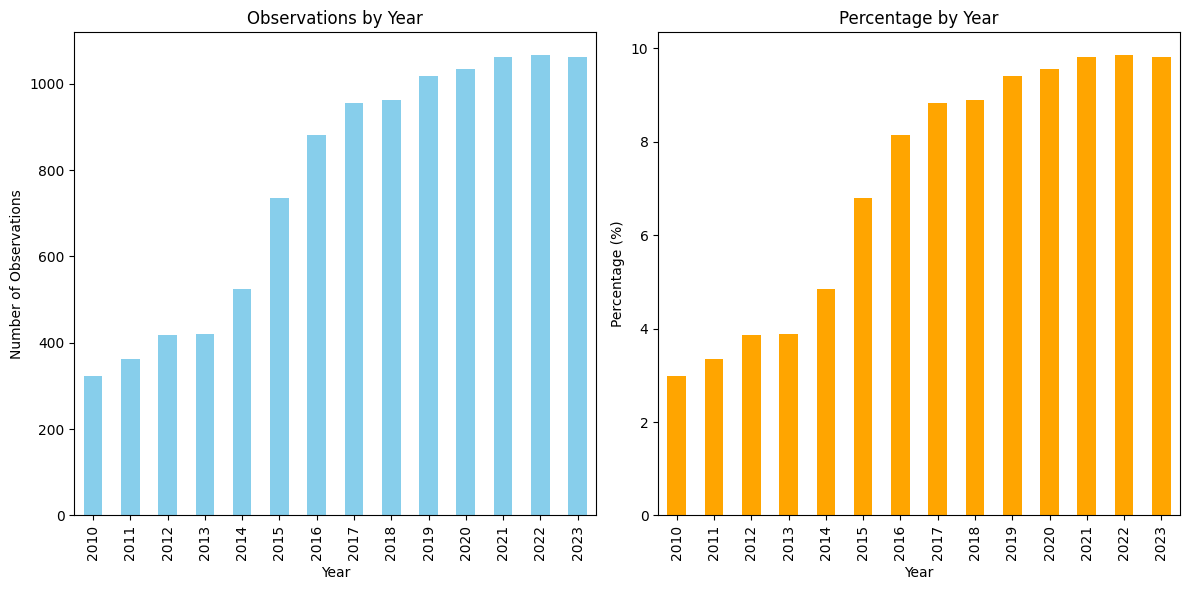

In [15]:
counts = nonfin_df.index.get_level_values('Year').value_counts().sort_index()
percentages = (counts / counts.sum()) * 100
summary_nonfin_df = pd.DataFrame({'Observations': counts, 'Percentage (%)': percentages})
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
summary_nonfin_df['Observations'].plot(kind='bar', ax=ax[0], color='skyblue', title='Observations by Year')
ax[0].set_ylabel('Number of Observations')
summary_nonfin_df['Percentage (%)'].plot(kind='bar', ax=ax[1], color='orange', title='Percentage by Year')
ax[1].set_ylabel('Percentage (%)')
plt.tight_layout()
plt.show()
summary_nonfin_df.loc['Total'] = {'Observations': len(nonfin_df), 'Percentage (%)': 100}
summary_nonfin_df.to_csv(f'csv/summary_nonfin_year.csv',index=True)

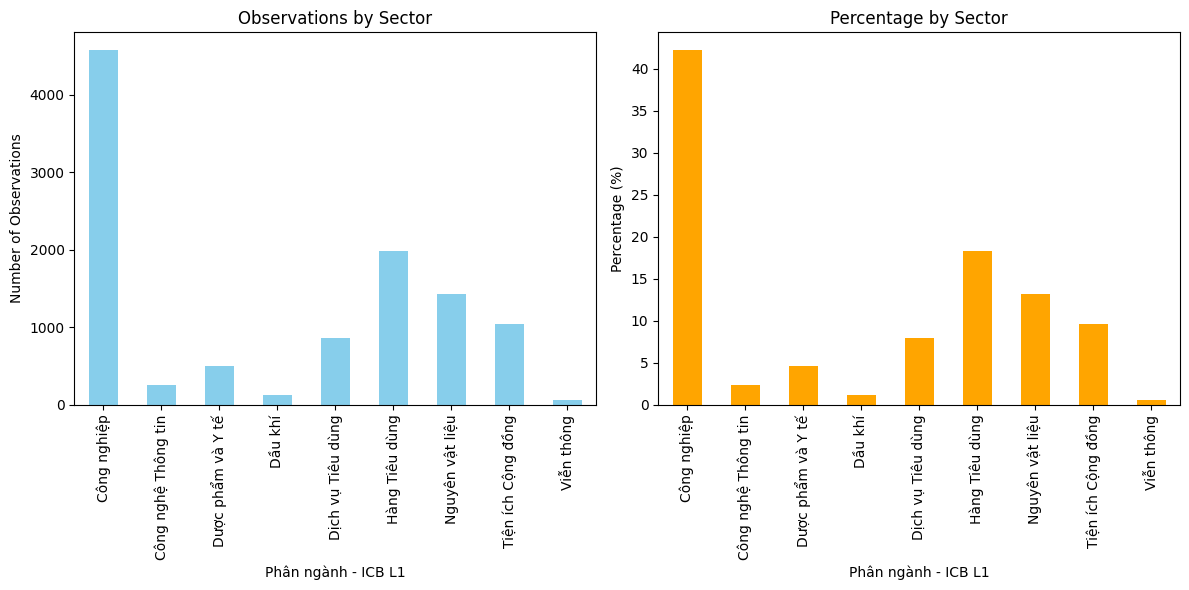

In [16]:
counts = nonfin_df.index.get_level_values('Phân ngành - ICB L1').value_counts().sort_index()
percentages = (counts / counts.sum()) * 100
summary_nonfin_df = pd.DataFrame({'Observations': counts, 'Percentage (%)': percentages})
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
summary_nonfin_df['Observations'].plot(kind='bar', ax=ax[0], color='skyblue', title='Observations by Sector')
ax[0].set_ylabel('Number of Observations')
summary_nonfin_df['Percentage (%)'].plot(kind='bar', ax=ax[1], color='orange', title='Percentage by Sector')
ax[1].set_ylabel('Percentage (%)')
plt.tight_layout()
plt.show()
summary_nonfin_df.loc['Total'] = {'Observations': len(nonfin_df), 'Percentage (%)': 100}
summary_nonfin_df.to_csv(f'csv/summary_nonfin_sector.csv',index=True)

### Labeled Data

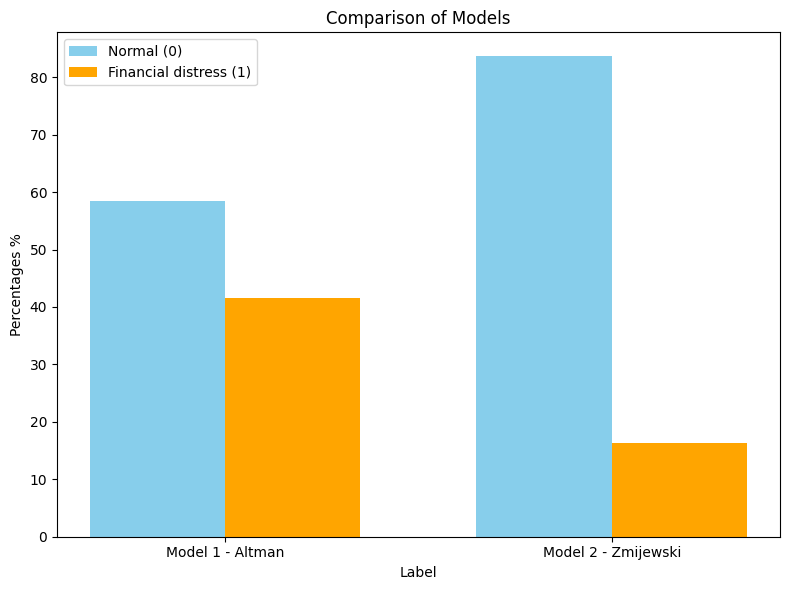

In [17]:
counts_1 = FD_iden_df['Model 1 - Altman'].value_counts()
counts_2 = FD_iden_df['Model 2 - Zmijewski'].value_counts()
percentages_1 = (counts_1 / counts_1.sum()) * 100
percentages_2 = (counts_2 / counts_2.sum()) * 100

summary_iden_df = pd.DataFrame({'Model 1 - Altman': percentages_1, 'Model 2 - Zmijewski': percentages_2})
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35
index = FD_iden_df.columns
x = range(len(index))

bar1 = ax.bar(index, summary_iden_df.loc[0], bar_width, label='Normal (0)', color='skyblue')
bar2 = ax.bar([i + bar_width for i in x], summary_iden_df.loc[1], bar_width, label='Financial distress (1)', color='orange')

ax.set_xlabel('Label')
ax.set_ylabel('Percentages %')
ax.set_title('Comparison of Models')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(index)
ax.legend()

plt.tight_layout()
plt.show()

summary_iden_df.insert(0, 'Label', ['Normal', 'Financial distress'])
summary_iden_df.set_index(['Label'], inplace=True)
summary_iden_df.to_csv(f'csv/summary_iden.csv',index=True)

### Features

https://www.investopedia.com/terms/s/statistics.asp
https://www.investopedia.com/terms/d/descriptive_statistics.asp

In [28]:
summary_stats = atr.describe().T[['count', 'mean', 'std', 'min', 'max']]
summary_stats = summary_stats.rename(columns={
    'count': 'Obs.',
    'mean': 'Mean',
    'std': 'Std. Dev.',
    'min': 'Min',
    'max': 'Max'
})
summary_stats.reset_index(inplace=True)
summary_stats.rename(columns={'index': 'Feature'}, inplace=True)

print(summary_stats)

                            Feature     Obs.         Mean      Std. Dev.  \
0                   X1: EBIT Margin  10826.0    -0.032225       5.234917   
1                 X2: EBITDA Margin  10826.0     0.032735       5.213808   
2                 X3: Current ratio  10826.0     2.373759       6.802683   
3                   X4: Quick ratio  10826.0     1.832860       5.817850   
4                    X5: Cash ratio  10826.0     0.490348       2.162903   
5                          X6: WCTA  10826.0     0.141918       0.515328   
6                     X7: D/E ratio  10826.0     2.104752      33.215152   
7          X8: Receivables turnover  10826.0    75.756200    1895.658198   
8            X9: Inventory turnover  10826.0  2895.345358  115275.489064   
9                  X10: AP turnover  10826.0    34.231821     538.752733   
10              X11: Asset turnover  10826.0     1.285964       1.461347   
11     X12: Current assets turnover  10826.0     2.414589       3.181665   
12          

#### Features Selection

https://chatgpt.com/share/67580f67-2c2c-8009-86f7-eddd4f38bf67

https://stats.stackexchange.com/questions/557974/whats-the-correct-approach-to-measure-correlation-in-binary-problems

In [ ]:
target_feature = {
    # 'Model 1 - Altman' : atr_1
}

for FD_model in FD_iden_df.columns:
    # Calculate correlation between features and target (FD models)
    correlation_matrix = atr.corrwith(FD_iden_df[FD_model])
    correlation_df = correlation_matrix.reindex(correlation_matrix.abs().sort_values(ascending=False).index)
    target_feature [f'{FD_model}'] = correlation_df[:10]

for FD_model, feature in target_feature.items():
    print(FD_model)
    print(feature)
    print('-------------------------')
    

Model 1 - Altman
X13: ROA %                        -0.411938
X11: Asset turnover               -0.360128
X24: Basic EPS                    -0.309156
X6: WCTA                          -0.303428
X23: Total Debt on Total Assets    0.295539
X12: Current assets turnover      -0.197824
X3: Current ratio                 -0.136490
X4: Quick ratio                   -0.133680
X5: Cash ratio                    -0.110673
X16: Gross Profit Margin          -0.082008
dtype: float64
-------------------------
Model 2 - Zmijewski
X23: Total Debt on Total Assets    0.414315
X13: ROA %                        -0.354254
X6: WCTA                          -0.349694
X24: Basic EPS                    -0.243463
X16: Gross Profit Margin          -0.129264
X3: Current ratio                 -0.095819
X4: Quick ratio                   -0.095687
X5: Cash ratio                    -0.084439
X11: Asset turnover               -0.082406
X7: D/E ratio                      0.070171
dtype: float64
-------------------------
[

In [ ]:
# target_feature = {
#     # 'Model 1 - Altman' : atr_1
# }

# for FD_model in FD_iden_df.columns:
#     selector = SelectKBest(f_classif, k=10)  # k is the number of features to select
#     X_new = selector.fit_transform(atr, FD_iden_df[FD_model])

#     selected_features = atr.columns[selector.get_support()]
#     target_feature [f'{FD_model}'] = selected_features

# for FD_model, feature in target_feature.items():
#     print(FD_model)
#     print(feature)
#     print('-------------------------')

Model 1 - Altman
Index(['X3: Current ratio', 'X4: Quick ratio', 'X6: WCTA',
       'X11: Asset turnover', 'X12: Current assets turnover', 'X13: ROA %',
       'X23: Total Debt on Total Assets', 'X24: Basic EPS'],
      dtype='object')
-------------------------
Model 2 - Zmijewski
Index(['X3: Current ratio', 'X4: Quick ratio', 'X5: Cash ratio', 'X6: WCTA',
       'X13: ROA %', 'X16: Gross Profit Margin',
       'X23: Total Debt on Total Assets', 'X24: Basic EPS'],
      dtype='object')
-------------------------


# Methods implementation

https://chatgpt.com/share/67568844-e258-8009-b5b1-3904640ada05

In [19]:
# models_df = pd.concat([FD_iden_df, atr], axis=1)
# models_df

## ML Models


Training model for Model 1 - Altman...
Training Random Forest...
Best parameters for Random Forest: {'max_depth': 26, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 181}
Accuracy for Random Forest: 0.94
Class 0 - Precision: 0.93, Recall: 0.97, F1: 0.95
Class 1 - Precision: 0.95, Recall: 0.89, F1: 0.92
Training Decision Tree...
Best parameters for Decision Tree: {'max_depth': 26, 'min_samples_leaf': 5, 'min_samples_split': 4}
Accuracy for Decision Tree: 0.91
Class 0 - Precision: 0.92, Recall: 0.94, F1: 0.93
Class 1 - Precision: 0.91, Recall: 0.88, F1: 0.89
Training SVM...
Accuracy for SVM: 0.63
Class 0 - Precision: 0.61, Recall: 0.99, F1: 0.76
Class 1 - Precision: 0.87, Recall: 0.12, F1: 0.21


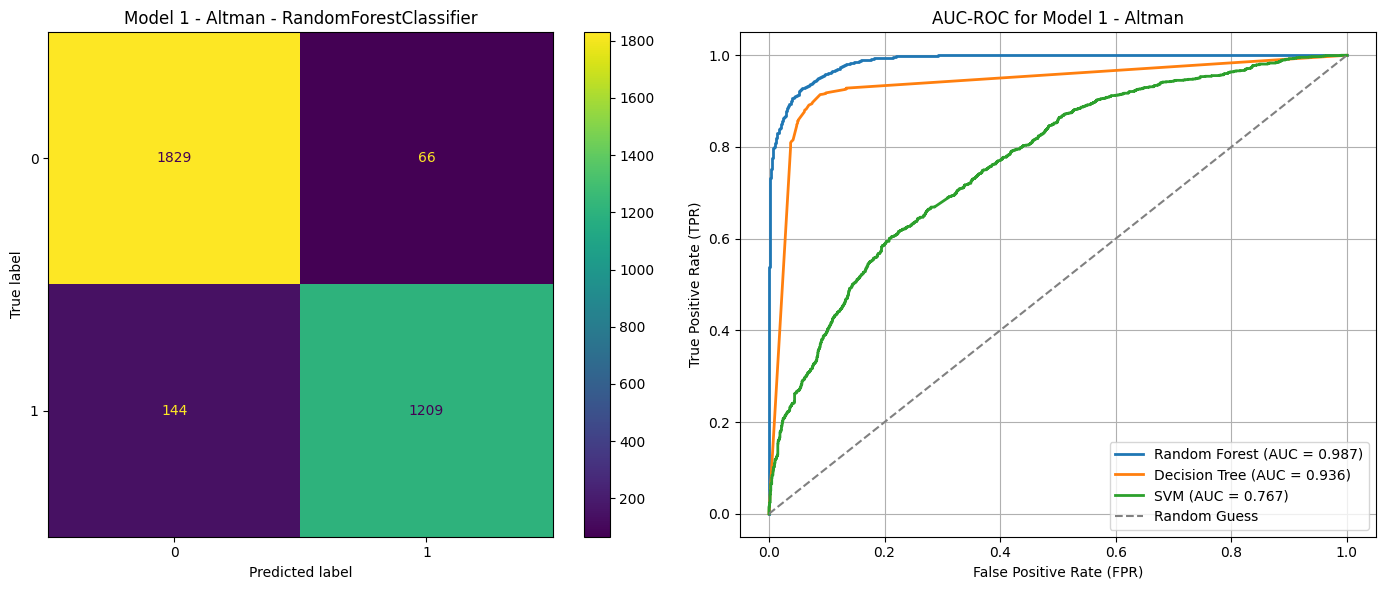


Training model for Model 2 - Zmijewski...
Training Random Forest...
Best parameters for Random Forest: {'max_depth': 17, 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 90}
Accuracy for Random Forest: 0.99
Class 0 - Precision: 1.00, Recall: 1.00, F1: 1.00
Class 1 - Precision: 0.98, Recall: 0.98, F1: 0.98
Training Decision Tree...
Best parameters for Decision Tree: {'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 15}
Accuracy for Decision Tree: 1.00
Class 0 - Precision: 1.00, Recall: 1.00, F1: 1.00
Class 1 - Precision: 0.99, Recall: 0.98, F1: 0.99
Training SVM...
Accuracy for SVM: 0.83
Class 0 - Precision: 0.83, Recall: 1.00, F1: 0.91
Class 1 - Precision: 0.25, Recall: 0.00, F1: 0.00


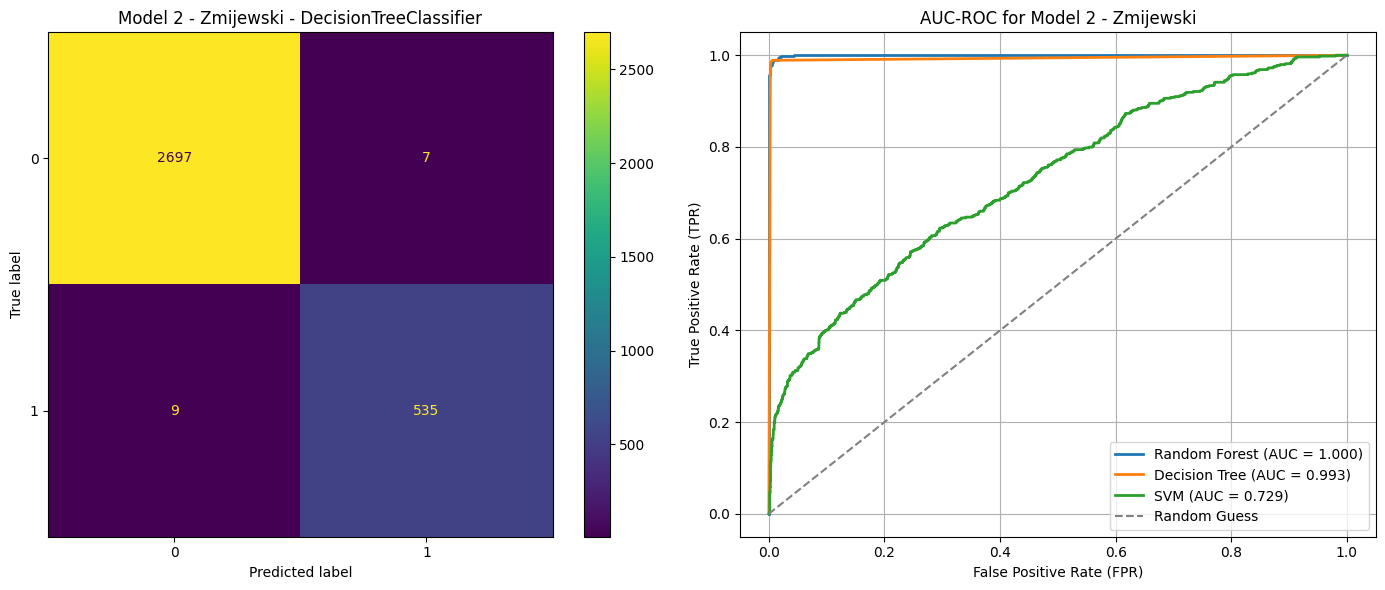

In [45]:
# ML models
ml_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# ML trained models
trained_ml_models = {}

# Store the performance results for comparison
performance_results = []

# Iterate over each label column in FD_inde_df
for FD_model in FD_iden_df.columns:
    print(f"\nTraining model for {FD_model}...")
    
    # # Selected features
    # filter_features = target_feature[FD_model].index.to_list()
    # selected_features = atr[filter_features]
    
    # Splitting data
    X_train, X_test, y_train, y_test = train_test_split(atr, FD_iden_df[FD_model], test_size=0.3, random_state=42)
    
    best_model = None
    best_accuracy = 0
    
    # Train each model and evaluate
    for model_name, model in ml_models.items():
        print(f"Training {model_name}...")
        
        # Hyperparameter tuning
        if model_name == 'Random Forest':
            param_distributions = {
                'n_estimators': randint(10, 300),
                'max_depth': randint(3, 30),
                'min_samples_split': randint(2, 30),
                'min_samples_leaf': randint(1, 30)
            }
            search = RandomizedSearchCV(model, param_distributions, n_iter=50, scoring='accuracy', cv=10, random_state=42, n_jobs=-1)
            search.fit(X_train, y_train)
            model = search.best_estimator_
            print(f"Best parameters for {model_name}: {search.best_params_}")
        elif model_name == 'Decision Tree':
            param_distributions = {
                'max_depth': randint(3, 30),
                'min_samples_split': randint(2, 30),
                'min_samples_leaf': randint(1, 30)
            }
            search = RandomizedSearchCV(model, param_distributions, n_iter=50, scoring='accuracy', cv=10, random_state=42, n_jobs=-1)
            search.fit(X_train, y_train)
            model = search.best_estimator_
            print(f"Best parameters for {model_name}: {search.best_params_}")
        elif model_name == 'SVM':
            model = model.fit(X_train, y_train)
        # Cross-validated performance
        # cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        # print(f"Cross-validated accuracy for {model_name}: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
        
        # Predictions
        y_pred = model.predict(X_test)
        
        # Evaluation
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=None)
        recall = recall_score(y_test, y_pred, average=None)
        f1 = f1_score(y_test, y_pred, average=None)
        
        print(f"Accuracy for {model_name}: {accuracy:.2f}")
        for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
            print(f"Class {i} - Precision: {p:.2f}, Recall: {r:.2f}, F1: {f:.2f}")
        
        # Store the performance
        performance_results.append({
            'FD Model': FD_model,
            'ML Model': model_name,
            'Accuracy': accuracy,
            'Precision (0)': precision[0],
            'Precision (1)': precision[1],
            'Recall (0)': recall[0],
            'Recall (1)': recall[1],
            'F1 (0)': f1[0],
            'F1 (1)': f1[1]
        })
        
        # Store the model
        trained_ml_models[f'{model_name}'] = model
        
        # Best accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
    
    # Create DataFrame to compare model performance
    performance_df = pd.DataFrame(performance_results)

    # Plot confusion matrix for the best model
    cm = confusion_matrix(y_test, best_model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    disp.plot(ax=ax[0], cmap='viridis')
    ax[0].set_title(f'{FD_model} - {best_model.__class__.__name__}')

    # Calculate and Plot AUC-ROC for all models
    for model_name, model in trained_ml_models.items():
        # if model_name == 'SVM':  # For SVM and other models that might need probability prediction
        #     model.probability = True
        
        # Calculate AUC-ROC if applicable
        if len(model.classes_) == 2:  # Binary classification
            y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
            auc_score = roc_auc_score(y_test, y_prob)
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            
            ax[1].plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc_score:.3f})')
    
    ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
    ax[1].set_title(f'AUC-ROC for {FD_model}')
    ax[1].set_xlabel('False Positive Rate (FPR)')
    ax[1].set_ylabel('True Positive Rate (TPR)')
    ax[1].legend(loc='lower right')
    ax[1].grid()
    
    plt.tight_layout()
    plt.show()
    
    

In [46]:
performance_df.to_csv(f'csv/all_fea_perform.csv',index=False)

## Random Forest

In [22]:
# # Define the model and hyperparameter grid
    # rf = RandomForestClassifier(random_state=42)
    # param_distributions = {
    #     'n_estimators': randint(10, 300),
    #     'max_depth': randint(3, 30),
    #     'min_samples_split': randint(2, 30),
    #     'min_samples_leaf': randint(1, 30)
    # }
    
    # # Hyperparameter tuning
    # search = RandomizedSearchCV(rf, param_distributions, n_iter=50, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
    # search.fit(X_train, y_train)
    
    # # Best model
    # best_rf = search.best_estimator_
    # print(f"Best parameters for {label}: {search.best_params_}")
    
    # # Cross-validated performance
    # cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
    # print(f"Cross-validated accuracy for {label}: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
    
    # # Predictions
    # y_pred = best_rf.predict(X_test)
    
    # # Evaluation
    # accuracy = accuracy_score(y_test, y_pred)
    # precision = precision_score(y_test, y_pred, average='weighted')
    # recall = recall_score(y_test, y_pred, average='weighted')
    
    # print(f"Accuracy for {label}: {accuracy:.2f}")
    # print(f"Precision for {label}: {precision:.2f}")
    # print(f"Recall for {label}: {recall:.2f}")
    
    # # Confusion matrix
    # cm = confusion_matrix(y_test, y_pred)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
    
    # # Plot Confusion Matrix
    # fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    # disp.plot(ax=ax[0], cmap='viridis')
    # ax[0].set_title(f'Confusion Matrix for {label}')
    
    # # Calculate and Plot AUC-ROC
    # if len(best_rf.classes_) == 2:  # Binary classification
    #     y_prob = best_rf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    #     auc_score = roc_auc_score(y_test, y_prob)
    #     fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        
    #     ax[1].plot(fpr, tpr, color='blue', lw=2, label=f'Random Forest (AUC = {auc_score:.3f})')
    #     ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
    #     ax[1].set_title(f'ROC Curve for {label}')
    #     ax[1].set_xlabel('False Positive Rate (FPR)')
    #     ax[1].set_ylabel('True Positive Rate (TPR)')
    #     ax[1].legend(loc='lower right')
    #     ax[1].grid()
    # else:
    #     ax[1].text(0.5, 0.5, 'AUC-ROC not applicable for multiclass classification',
    #                horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
    #     ax[1].set_title(f'No ROC Curve for {label}')
    #     ax[1].axis('off')
    
    # plt.tight_layout()
    # plt.show()